# gan
- gan, cgan
- pix2pix

- 숫자 이미지 생성
- 채색

## cGAN
- Conditional Generative Adversarial Nets (cGAN)은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여,
내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법

![](https://aiffelstaticprd.blob.core.windows.net/media/images/cgan_img.max-800x600.png)

## data import
```
 pip install tensorflow-datasets
    ```

In [36]:
# mnist data set

import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [11]:
## data set gan / cgan 용 분리
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # 256  1 ~ -1로 값 조정.
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10) # one hot  label< 적용 
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

NameError: name 'mnist' is not defined

In [12]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

NameError: name 'cgan_datasets' is not defined

# generator

## gan generator

In [13]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


## cgan generartor

In [14]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


# disicriminator

## gan discriminator

In [15]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x) # fc layer 학습 시키기 위해...
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


## cGan disicriminator

- maxout : 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록
- 24-5

### mxaout

- units 차원의 representatoin을 pieces개만큼 만들고 그 중 최댓 값 1개 차원만 출력

In [16]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


- cgan discriminator 는 maxout layer 활용

In [17]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# GAN

## model set
- 찐, 짭 구별을 위해  Binary Cross Entropy를 사용
- adam optimizer이용

- 각 generator / disicirimnator 셋팅

In [18]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    



In [19]:
# 노이즈를 100차원으로 설정
#

In [20]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    # 평균이 100인 이미지 사이즈의 랜덤 난수 생성,..........
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

print("✅")

✅


## train

In [21]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

NameError: name 'gan_datasets' is not defined

## test

In [34]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

AttributeError: 'Tensor' object has no attribute 'numpy'

## epoch 500  weight

In [ ]:
# 500 epch pretrained model upload
! wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

In [ ]:
import os
weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'
#weight_path ='./GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# CGAN

In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

## epoch 500 weight upload

In [23]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
!unzip CGAN_500.zip

--2020-11-11 18:03:45--  https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2579076 (2.5M) [application/zip]
Saving to: ‘CGAN_500.zip.1’

CGAN_500.zip.1      100%[===================>]   2.46M  15.0MB/s    in 0.2s    

2020-11-11 18:03:45 (15.0 MB/s) - ‘CGAN_500.zip.1’ saved [2579076/2579076]

Archive:  CGAN_500.zip
  inflating: CGAN_500.index          
  inflating: CGAN_500.data-00001-of-00002  
  inflating: CGAN_500.data-00000-of-00002  


In [24]:
number =  7 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500: Not found: /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN; No such file or directory

# pix2pix_ generator
   
   
- conv 레이어를 통해 이미지 다운 샘플링 representation 학습 -bottleneck
- 다시 conv 레리어로 upsampling , 입력 이미지와 동일한 크기.로 생성.



![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator.max-800x600.png)

## u-net

- skip connection
- 인토더의 상위 레이어의 결과를 decoder로 연결하여
- 비교적 선명한 결과를 얻을tn
![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator_unet.max-800x600.png)

## PIX2PIX DISCRIMINATOR
- CONV LAYER   
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/dcgan_d.png)
![](https://aiffelstaticprd.blob.core.windows.net/media/images/patchgan.max-800x600.png)


- 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출
   
   
- 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN
- 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것

# 실습 채색

## Sketch2Pokemon DATA SET DONWLOAD
- https://www.kaggle.com/norod78/sketch2pokemon


In [25]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
!unzip sketch2pokemon.zip

--2020-11-11 18:03:46--  https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66732281 (64M) [application/zip]
Saving to: ‘sketch2pokemon.zip’

sketch2pokemon.zip   75%[==============>     ]  48.29M  12.6MB/s    eta 2s     ^C
Archive:  sketch2pokemon.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of sketch2pokemon.zip or
        sketch2pokemon.zip.zip, and cannot find sketch2pokemon.zip.ZIP, period.


In [26]:
!ls

01-basic-Copy1.ipynb	      CGAN_500.zip
01-basic.ipynb		      CGAN_500.zip.1
02-prj.ipynb		      GAN_500.zip
CGAN_500.data-00000-of-00002  pokemon_pix2pix_dataset
CGAN_500.data-00001-of-00002  sketch2pokemon.zip
CGAN_500.index


## DATA SET IMPORT

In [27]:
import os
#+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'

data_path =  './pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


In [28]:
!pwd

/home/ubuntu/lsg/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img


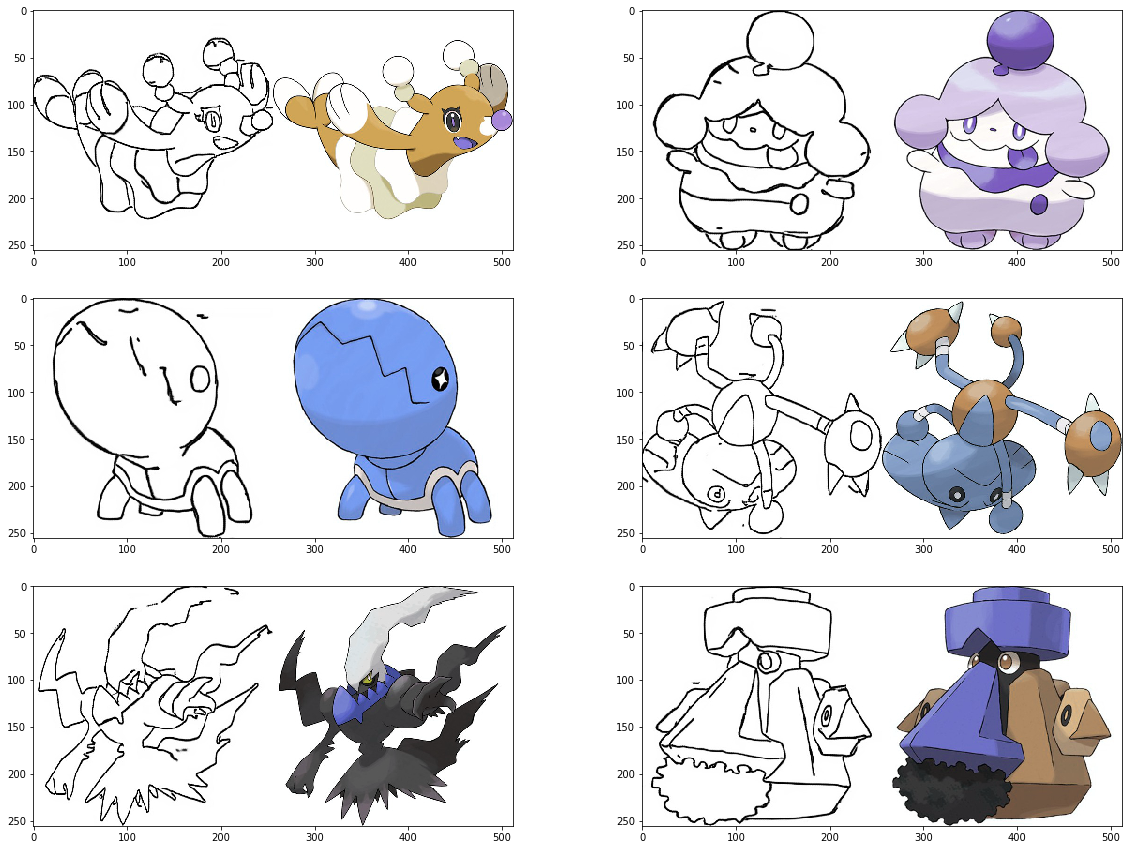

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## IMG 처리

In [30]:
# 이미지 사이즈

In [31]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## IMG 분리

In [32]:
# 이미지 분할
# 반타작

AttributeError: 'Tensor' object has no attribute 'numpy'

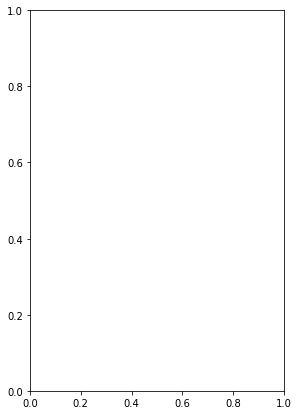

In [33]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## AUGMENTATION 

In [ ]:
# 자르고 위아래, 왼좌 전환, 

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 15

In [ ]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [ ]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## architecture

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/paper_g.png)

![](https://aiffelstaticprd.blob.core.windows.net/media/images/refer_g.max-800x600.png)

## generator_block ()


```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn: # encoder 첫번째 레이어 배치 놈 안씀.
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

In [ ]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 필터(커널) 개수 리스트)
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0: # 첫번째 레이어 배치놈 사용 안함(feat. 논문
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape) # is used to instantiate a Keras tensor
                       
        return Model(inputs, self.call(inputs)).summary()



In [32]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

## decoder_bloack(

In [33]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [34]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

## encoder+ decoder

In [35]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## unet, (skip connection 추가)

### unet - generator

In [36]:
# 요건 그대로임

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [37]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [38]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### unet - discriminator

In [39]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [40]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [41]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [42]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

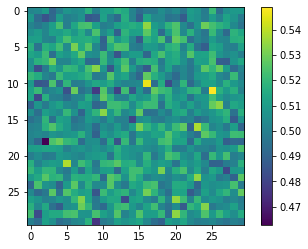

In [43]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## train


In [44]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [45]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [50]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [51]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:2.4009                     
L1_loss:0.2937                     
Discriminator_loss:3.2989

EPOCH[1] - STEP[20]                     
Generator_loss:0.6393                     
L1_loss:0.2753                     
Discriminator_loss:1.6907

EPOCH[1] - STEP[30]                     
Generator_loss:0.6305                     
L1_loss:0.3170                     
Discriminator_loss:1.4598

EPOCH[1] - STEP[40]                     
Generator_loss:0.7150                     
L1_loss:0.2592                     
Discriminator_loss:1.3638

EPOCH[1] - STEP[50]                     
Generator_loss:0.8144                     
L1_loss:0.2071                     
Discriminator_loss:1.3193

EPOCH[1] - STEP[60]                     
Generator_loss:0.7962                     
L1_loss:0.2367                     
Discriminator_loss:1.3838

EPOCH[1] - STEP[70]                     
Generator_loss:0.9338                     
L1_loss:0.2232                    

EPOCH[3] - STEP[170]                     
Generator_loss:1.7048                     
L1_loss:0.2896                     
Discriminator_loss:0.3096

EPOCH[3] - STEP[180]                     
Generator_loss:1.1771                     
L1_loss:0.2987                     
Discriminator_loss:0.4804

EPOCH[3] - STEP[190]                     
Generator_loss:2.1302                     
L1_loss:0.2565                     
Discriminator_loss:0.2065

EPOCH[3] - STEP[200]                     
Generator_loss:2.8064                     
L1_loss:0.2510                     
Discriminator_loss:0.6847

EPOCH[4] - STEP[10]                     
Generator_loss:2.6721                     
L1_loss:0.2501                     
Discriminator_loss:0.2481

EPOCH[4] - STEP[20]                     
Generator_loss:2.1267                     
L1_loss:0.2207                     
Discriminator_loss:1.2004

EPOCH[4] - STEP[30]                     
Generator_loss:2.0133                     
L1_loss:0.2122                

EPOCH[6] - STEP[130]                     
Generator_loss:0.1463                     
L1_loss:0.2393                     
Discriminator_loss:2.3376

EPOCH[6] - STEP[140]                     
Generator_loss:1.3843                     
L1_loss:0.2745                     
Discriminator_loss:0.5280

EPOCH[6] - STEP[150]                     
Generator_loss:2.7848                     
L1_loss:0.3016                     
Discriminator_loss:1.1958

EPOCH[6] - STEP[160]                     
Generator_loss:3.2527                     
L1_loss:0.2874                     
Discriminator_loss:0.1939

EPOCH[6] - STEP[170]                     
Generator_loss:0.9135                     
L1_loss:0.2632                     
Discriminator_loss:0.6551

EPOCH[6] - STEP[180]                     
Generator_loss:2.5873                     
L1_loss:0.2613                     
Discriminator_loss:0.5739

EPOCH[6] - STEP[190]                     
Generator_loss:1.4530                     
L1_loss:0.2354             

EPOCH[9] - STEP[90]                     
Generator_loss:2.1269                     
L1_loss:0.2232                     
Discriminator_loss:1.4744

EPOCH[9] - STEP[100]                     
Generator_loss:1.6659                     
L1_loss:0.2456                     
Discriminator_loss:1.0517

EPOCH[9] - STEP[110]                     
Generator_loss:1.9313                     
L1_loss:0.2236                     
Discriminator_loss:0.5405

EPOCH[9] - STEP[120]                     
Generator_loss:2.7751                     
L1_loss:0.2679                     
Discriminator_loss:1.5293

EPOCH[9] - STEP[130]                     
Generator_loss:1.9642                     
L1_loss:0.2329                     
Discriminator_loss:0.4270

EPOCH[9] - STEP[140]                     
Generator_loss:1.3540                     
L1_loss:0.2156                     
Discriminator_loss:1.1651

EPOCH[9] - STEP[150]                     
Generator_loss:1.3076                     
L1_loss:0.1700              

EPOCH[12] - STEP[50]                     
Generator_loss:4.3702                     
L1_loss:0.2191                     
Discriminator_loss:2.7480

EPOCH[12] - STEP[60]                     
Generator_loss:1.9155                     
L1_loss:0.2699                     
Discriminator_loss:0.2591

EPOCH[12] - STEP[70]                     
Generator_loss:2.5706                     
L1_loss:0.2215                     
Discriminator_loss:0.5786

EPOCH[12] - STEP[80]                     
Generator_loss:0.7579                     
L1_loss:0.2431                     
Discriminator_loss:0.8411

EPOCH[12] - STEP[90]                     
Generator_loss:1.8358                     
L1_loss:0.2370                     
Discriminator_loss:2.1206

EPOCH[12] - STEP[100]                     
Generator_loss:1.0320                     
L1_loss:0.2519                     
Discriminator_loss:0.9634

EPOCH[12] - STEP[110]                     
Generator_loss:1.7810                     
L1_loss:0.2460           

EPOCH[15] - STEP[10]                     
Generator_loss:1.4113                     
L1_loss:0.2484                     
Discriminator_loss:0.5887

EPOCH[15] - STEP[20]                     
Generator_loss:1.0143                     
L1_loss:0.2133                     
Discriminator_loss:0.7998

EPOCH[15] - STEP[30]                     
Generator_loss:2.9856                     
L1_loss:0.2482                     
Discriminator_loss:0.8441

EPOCH[15] - STEP[40]                     
Generator_loss:1.6276                     
L1_loss:0.2262                     
Discriminator_loss:0.4884

EPOCH[15] - STEP[50]                     
Generator_loss:1.4895                     
L1_loss:0.2603                     
Discriminator_loss:0.8051

EPOCH[15] - STEP[60]                     
Generator_loss:1.1237                     
L1_loss:0.2577                     
Discriminator_loss:0.8313

EPOCH[15] - STEP[70]                     
Generator_loss:2.0593                     
L1_loss:0.2106             

EPOCH[17] - STEP[170]                     
Generator_loss:2.3728                     
L1_loss:0.1955                     
Discriminator_loss:1.6497

EPOCH[17] - STEP[180]                     
Generator_loss:3.6475                     
L1_loss:0.2298                     
Discriminator_loss:2.6967

EPOCH[17] - STEP[190]                     
Generator_loss:1.7425                     
L1_loss:0.2287                     
Discriminator_loss:0.9737

EPOCH[17] - STEP[200]                     
Generator_loss:1.8774                     
L1_loss:0.2764                     
Discriminator_loss:0.2722

EPOCH[18] - STEP[10]                     
Generator_loss:1.7019                     
L1_loss:0.2073                     
Discriminator_loss:0.7329

EPOCH[18] - STEP[20]                     
Generator_loss:1.9900                     
L1_loss:0.2455                     
Discriminator_loss:0.2091

EPOCH[18] - STEP[30]                     
Generator_loss:1.0770                     
L1_loss:0.2493         

EPOCH[20] - STEP[130]                     
Generator_loss:1.5720                     
L1_loss:0.1988                     
Discriminator_loss:0.3550

EPOCH[20] - STEP[140]                     
Generator_loss:2.0439                     
L1_loss:0.2509                     
Discriminator_loss:0.2545

EPOCH[20] - STEP[150]                     
Generator_loss:1.4348                     
L1_loss:0.3060                     
Discriminator_loss:0.4660

EPOCH[20] - STEP[160]                     
Generator_loss:2.7350                     
L1_loss:0.2351                     
Discriminator_loss:1.1895

EPOCH[20] - STEP[170]                     
Generator_loss:1.9523                     
L1_loss:0.2647                     
Discriminator_loss:0.3821

EPOCH[20] - STEP[180]                     
Generator_loss:1.7063                     
L1_loss:0.2543                     
Discriminator_loss:1.4649

EPOCH[20] - STEP[190]                     
Generator_loss:1.9964                     
L1_loss:0.2366      

EPOCH[23] - STEP[90]                     
Generator_loss:2.5015                     
L1_loss:0.2296                     
Discriminator_loss:0.3084

EPOCH[23] - STEP[100]                     
Generator_loss:2.6624                     
L1_loss:0.2453                     
Discriminator_loss:0.6314

EPOCH[23] - STEP[110]                     
Generator_loss:2.9338                     
L1_loss:0.2330                     
Discriminator_loss:1.3241

EPOCH[23] - STEP[120]                     
Generator_loss:1.2430                     
L1_loss:0.2438                     
Discriminator_loss:0.6804

EPOCH[23] - STEP[130]                     
Generator_loss:0.8889                     
L1_loss:0.2059                     
Discriminator_loss:0.7509

EPOCH[23] - STEP[140]                     
Generator_loss:1.3348                     
L1_loss:0.2290                     
Discriminator_loss:0.4970

EPOCH[23] - STEP[150]                     
Generator_loss:2.5114                     
L1_loss:0.2425       

EPOCH[26] - STEP[50]                     
Generator_loss:2.0082                     
L1_loss:0.2450                     
Discriminator_loss:0.2059

EPOCH[26] - STEP[60]                     
Generator_loss:2.2460                     
L1_loss:0.3848                     
Discriminator_loss:0.1987

EPOCH[26] - STEP[70]                     
Generator_loss:1.9459                     
L1_loss:0.2290                     
Discriminator_loss:2.0596

EPOCH[26] - STEP[80]                     
Generator_loss:1.5719                     
L1_loss:0.2336                     
Discriminator_loss:1.2706

EPOCH[26] - STEP[90]                     
Generator_loss:1.6138                     
L1_loss:0.1898                     
Discriminator_loss:0.3452

EPOCH[26] - STEP[100]                     
Generator_loss:2.5322                     
L1_loss:0.2217                     
Discriminator_loss:1.0338

EPOCH[26] - STEP[110]                     
Generator_loss:1.5355                     
L1_loss:0.2654           

EPOCH[29] - STEP[10]                     
Generator_loss:0.4873                     
L1_loss:0.1939                     
Discriminator_loss:1.8634

EPOCH[29] - STEP[20]                     
Generator_loss:1.0396                     
L1_loss:0.2194                     
Discriminator_loss:0.6061

EPOCH[29] - STEP[30]                     
Generator_loss:3.6761                     
L1_loss:0.2397                     
Discriminator_loss:1.0874

EPOCH[29] - STEP[40]                     
Generator_loss:2.4273                     
L1_loss:0.2006                     
Discriminator_loss:1.1818

EPOCH[29] - STEP[50]                     
Generator_loss:2.1538                     
L1_loss:0.2410                     
Discriminator_loss:0.4241

EPOCH[29] - STEP[60]                     
Generator_loss:0.7798                     
L1_loss:0.1979                     
Discriminator_loss:1.2680

EPOCH[29] - STEP[70]                     
Generator_loss:1.8392                     
L1_loss:0.2384             

EPOCH[31] - STEP[170]                     
Generator_loss:0.6122                     
L1_loss:0.1929                     
Discriminator_loss:1.1371

EPOCH[31] - STEP[180]                     
Generator_loss:2.7024                     
L1_loss:0.2485                     
Discriminator_loss:0.1181

EPOCH[31] - STEP[190]                     
Generator_loss:1.2747                     
L1_loss:0.2668                     
Discriminator_loss:0.4889

EPOCH[31] - STEP[200]                     
Generator_loss:0.4930                     
L1_loss:0.2228                     
Discriminator_loss:1.6836

EPOCH[32] - STEP[10]                     
Generator_loss:2.2696                     
L1_loss:0.2871                     
Discriminator_loss:0.2456

EPOCH[32] - STEP[20]                     
Generator_loss:2.5167                     
L1_loss:0.1935                     
Discriminator_loss:1.8040

EPOCH[32] - STEP[30]                     
Generator_loss:2.1868                     
L1_loss:0.1692         

EPOCH[34] - STEP[130]                     
Generator_loss:1.9549                     
L1_loss:0.2407                     
Discriminator_loss:0.8743

EPOCH[34] - STEP[140]                     
Generator_loss:1.3408                     
L1_loss:0.2188                     
Discriminator_loss:0.7927

EPOCH[34] - STEP[150]                     
Generator_loss:3.1946                     
L1_loss:0.2400                     
Discriminator_loss:2.5009

EPOCH[34] - STEP[160]                     
Generator_loss:1.0162                     
L1_loss:0.2794                     
Discriminator_loss:0.8433

EPOCH[34] - STEP[170]                     
Generator_loss:1.9302                     
L1_loss:0.2869                     
Discriminator_loss:0.2573

EPOCH[34] - STEP[180]                     
Generator_loss:0.7490                     
L1_loss:0.2021                     
Discriminator_loss:0.9288

EPOCH[34] - STEP[190]                     
Generator_loss:1.1755                     
L1_loss:0.2120      

EPOCH[37] - STEP[90]                     
Generator_loss:2.7990                     
L1_loss:0.2250                     
Discriminator_loss:0.3377

EPOCH[37] - STEP[100]                     
Generator_loss:1.5995                     
L1_loss:0.2263                     
Discriminator_loss:0.4465

EPOCH[37] - STEP[110]                     
Generator_loss:2.0477                     
L1_loss:0.2511                     
Discriminator_loss:0.3989

EPOCH[37] - STEP[120]                     
Generator_loss:1.7395                     
L1_loss:0.2509                     
Discriminator_loss:0.2570

EPOCH[37] - STEP[130]                     
Generator_loss:1.3584                     
L1_loss:0.2029                     
Discriminator_loss:0.4974

EPOCH[37] - STEP[140]                     
Generator_loss:0.5372                     
L1_loss:0.2196                     
Discriminator_loss:1.0451

EPOCH[37] - STEP[150]                     
Generator_loss:0.4321                     
L1_loss:0.1875       

EPOCH[40] - STEP[50]                     
Generator_loss:2.6680                     
L1_loss:0.2924                     
Discriminator_loss:0.1401

EPOCH[40] - STEP[60]                     
Generator_loss:1.9842                     
L1_loss:0.3184                     
Discriminator_loss:0.5191

EPOCH[40] - STEP[70]                     
Generator_loss:2.3595                     
L1_loss:0.2493                     
Discriminator_loss:1.5069

EPOCH[40] - STEP[80]                     
Generator_loss:1.5349                     
L1_loss:0.2420                     
Discriminator_loss:0.8122

EPOCH[40] - STEP[90]                     
Generator_loss:1.1648                     
L1_loss:0.2129                     
Discriminator_loss:0.8705

EPOCH[40] - STEP[100]                     
Generator_loss:0.6289                     
L1_loss:0.2333                     
Discriminator_loss:0.9623

EPOCH[40] - STEP[110]                     
Generator_loss:2.4267                     
L1_loss:0.2311           

EPOCH[43] - STEP[10]                     
Generator_loss:2.9864                     
L1_loss:0.2282                     
Discriminator_loss:0.5236

EPOCH[43] - STEP[20]                     
Generator_loss:1.9014                     
L1_loss:0.2303                     
Discriminator_loss:1.0732

EPOCH[43] - STEP[30]                     
Generator_loss:0.5138                     
L1_loss:0.2148                     
Discriminator_loss:0.9960

EPOCH[43] - STEP[40]                     
Generator_loss:1.8762                     
L1_loss:0.2375                     
Discriminator_loss:0.2763

EPOCH[43] - STEP[50]                     
Generator_loss:0.5616                     
L1_loss:0.2745                     
Discriminator_loss:1.0292

EPOCH[43] - STEP[60]                     
Generator_loss:1.1028                     
L1_loss:0.2545                     
Discriminator_loss:0.4604

EPOCH[43] - STEP[70]                     
Generator_loss:4.3385                     
L1_loss:0.3161             

EPOCH[45] - STEP[170]                     
Generator_loss:1.0133                     
L1_loss:0.1777                     
Discriminator_loss:2.1258

EPOCH[45] - STEP[180]                     
Generator_loss:2.1662                     
L1_loss:0.2575                     
Discriminator_loss:0.2936

EPOCH[45] - STEP[190]                     
Generator_loss:2.3381                     
L1_loss:0.2357                     
Discriminator_loss:0.4240

EPOCH[45] - STEP[200]                     
Generator_loss:2.0566                     
L1_loss:0.2061                     
Discriminator_loss:0.7774

EPOCH[46] - STEP[10]                     
Generator_loss:2.1379                     
L1_loss:0.2869                     
Discriminator_loss:0.2238

EPOCH[46] - STEP[20]                     
Generator_loss:0.4160                     
L1_loss:0.2678                     
Discriminator_loss:1.2821

EPOCH[46] - STEP[30]                     
Generator_loss:2.4792                     
L1_loss:0.2314         

EPOCH[48] - STEP[130]                     
Generator_loss:0.5067                     
L1_loss:0.2251                     
Discriminator_loss:1.3918

EPOCH[48] - STEP[140]                     
Generator_loss:1.7503                     
L1_loss:0.2214                     
Discriminator_loss:0.4742

EPOCH[48] - STEP[150]                     
Generator_loss:0.8088                     
L1_loss:0.2835                     
Discriminator_loss:0.8312

EPOCH[48] - STEP[160]                     
Generator_loss:0.9819                     
L1_loss:0.2395                     
Discriminator_loss:0.6661

EPOCH[48] - STEP[170]                     
Generator_loss:1.0265                     
L1_loss:0.2160                     
Discriminator_loss:0.6239

EPOCH[48] - STEP[180]                     
Generator_loss:0.2654                     
L1_loss:0.1965                     
Discriminator_loss:1.6643

EPOCH[48] - STEP[190]                     
Generator_loss:1.4294                     
L1_loss:0.1807      

In [ ]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
test_ind = 2

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))